In [1]:
from collections import Counter
from concurrent.futures import ThreadPoolExecutor, as_completed
from io import BytesIO
import os
import warnings

import cv2
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image, ImageOps
import pandas as pd
import requests
from scipy.ndimage import label
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.utils.class_weight import compute_class_weight
from tqdm.notebook import tqdm

from era_data import TabletPeriodDataset, get_IDS, pad_zeros

# Ignore specific FutureWarnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='seaborn')

# Load Data

In [2]:
IMG_DIR = 'output/images_preprocessed'

IDS = get_IDS(IMG_DIR=IMG_DIR)
len(IDS)

94936

In [3]:
image_names = [os.path.splitext(file)[0] for file in os.listdir(IMG_DIR) if file.endswith('.png')]

In [11]:
df = pd.read_csv('output/cdli_catalogue_data.csv')

## Remove samples where the period is not in the group of defined periods, pad ID with zeros

In [5]:
df['id_text_normed']=[pad_zeros(x) for x in df['id_text']]

In [6]:
df = df[df['id_text_normed'].isin(image_names)]

In [7]:
df=df[(df['period_normed'].isin(TabletPeriodDataset.PERIOD_INDICES))&(df['era'].notnull())]

# Split the data to train-val-test sets

In [12]:
train_ids, test_ids = train_test_split(IDS, test_size=.2, random_state=0)
len(train_ids), len(test_ids)

(75948, 18988)

In [13]:
test_ids, val_ids = train_test_split(test_ids, test_size=.5, random_state=0)
len(test_ids), len(val_ids)

(9494, 9494)

In [14]:
ds_train = TabletPeriodDataset(IDS=train_ids, IMG_DIR=IMG_DIR, mask=True)
ds_val = TabletPeriodDataset(IDS=val_ids, IMG_DIR=IMG_DIR, mask=True)
ds_test = TabletPeriodDataset(IDS=test_ids, IMG_DIR=IMG_DIR, mask=True)

Filtering 94936 IDS down to provided 75948...
Filtering 94936 IDS down to provided 9494...
Filtering 94936 IDS down to provided 9494...


# Extract the biggest component of each image

In [11]:
def tablet_biggest_comp(binary_image):

    # Find connected components
    labeled_image, num_features = label(binary_image)

    # Calculate the sizes of the connected components
    component_sizes = np.bincount(labeled_image.ravel())

    # Find the label of the largest component (excluding background)
    largest_component_label = np.argmax(component_sizes[1:]) + 1

    # Create a mask for the largest component
    largest_component_mask = (labeled_image == largest_component_label)

    # Extract the largest component using the mask
    largest_component_image = binary_image * largest_component_mask

    return largest_component_image

def tablet_h_w_ratio(image):
    # Find contours in the binary image
    contours, _ = cv2.findContours(image.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Find the largest contour (object)
    largest_contour = max(contours, key=cv2.contourArea)

    # Calculate the bounding box of the largest contour
    x, y, w, h = cv2.boundingRect(largest_contour)

    # Calculate width and height
    width = w
    height = h
    return (h, w, round(height / width, 2))

## Display an original image and all of the possible preprocessing - greyscaled, masked and with largest component extracted

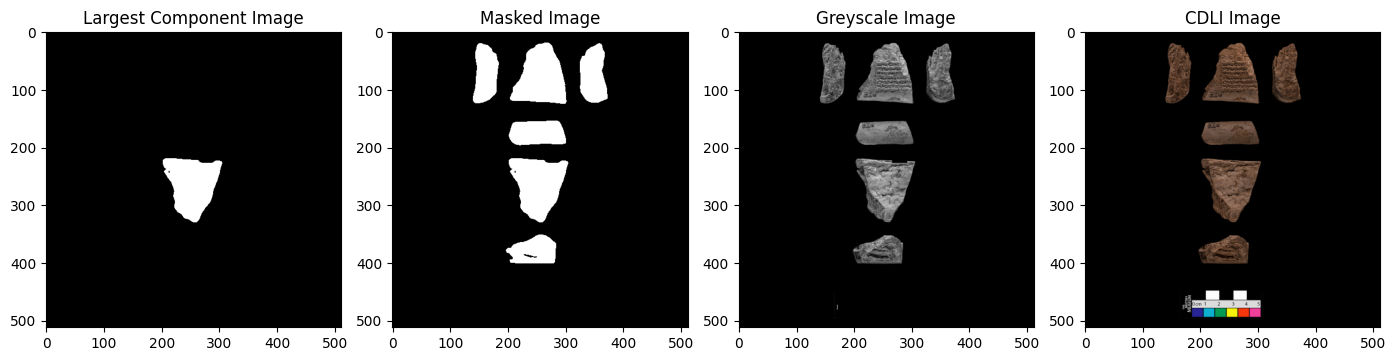

CDLI ID: 451880


In [12]:
id_img = 71748

plt.figure(figsize=(14, 5))  

# Process and display the largest component image
image = ds_train[id_img][1]
largest_component_image = tablet_biggest_comp(image)
plt.subplot(1, 4, 1)
plt.imshow(largest_component_image, cmap='gray')
plt.title('Largest Component Image')

# Display the masked image
plt.subplot(1, 4, 2)
plt.imshow(image, cmap='gray')
plt.title('Masked Image')

# Display the greyscale image
plt.subplot(1, 4, 3)
plt.imshow(Image.open(ds_train.img_fns[id_img]), cmap='gray')
plt.title('Greyscale Image')

# Construct URL and download the fourth image using the CDLI ID
cdli_id = ds_train[id_img][0]  # Extract the CDLI ID from your dataset
url = f"https://cdli.ucla.edu/dl/photo/P{cdli_id}.jpg"
response = requests.get(url)
fourth_image = Image.open(BytesIO(response.content))

# Resize the scraped image to 512x512 while keeping the aspect ratio
target_size = (512, 512)
fourth_image.thumbnail(target_size, Image.LANCZOS)
# Create a black background
background = Image.new("RGB", target_size, "black")
# Calculate the position to paste the resized image on the background
background.paste(fourth_image, (int((target_size[0] - fourth_image.width) / 2), int((target_size[1] - fourth_image.height) / 2)))

# Display the CDLI image
plt.subplot(1, 4, 4)
plt.imshow(background, cmap='gray')
plt.title('CDLI Image')

plt.tight_layout()
plt.show()

# Printing the CDLI ID
print("CDLI ID: " + cdli_id)


In [13]:
# Print the calculated width and height
image = ds_train[id_img][1]
largest_component_image = tablet_biggest_comp(image)
print("Ratio (Height/Width):", tablet_h_w_ratio(largest_component_image))

Ratio (Height/Width): (111, 103, 1.08)


## Calculate the Height/Width Ratio for all tablets - need to run only once, then load in next section

In [14]:
def calculate_ratio_and_extract_values(tablet_id, ds):
    biggest_component = tablet_biggest_comp(ds[tablet_id][1])
    h, w, ratio = tablet_h_w_ratio(biggest_component)
    values = [ds[tablet_id][2], ds[tablet_id][3]]  # Extract additional values
    return {'tablet_id': tablet_id, 'height': h, 'width': w, 'hw_ratio': ratio, 'period': values[0], 'genre': values[1]}

In [15]:
# Function to execute in parallel
def process_tablet_id(tablet_id, ds):
    return calculate_ratio_and_extract_values(tablet_id, ds)

In [16]:
def process_data_set(ds, dataset_name, num_workers=6):
    """
    Process a dataset using multithreading and save the results to a CSV file.

    Parameters:
    - ds: The dataset to process.
    - dataset_name: A string specifying the name for the dataset being processed (e.g., 'train', 'val', 'test').
    - num_workers: The number of threads to use for processing. The default is 6.
    """
    data_results = []

    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        # Create a list to hold the futures
        futures = [executor.submit(process_tablet_id, tablet_id, ds) for tablet_id in range(0, len(ds))]
        
        progress = tqdm(as_completed(futures), total=len(futures), desc=f'Processing Tablets: {dataset_name}')
        
        for future in progress:
            # As each future completes, append its result to the data list
            data_results.append(future.result())

    ratio_df = pd.DataFrame(data_results)

    filename = f"output/ratio_df_{dataset_name}.csv"
    
    ratio_df.to_csv(filename, index=False)
    print(f"Output saved to {filename}")

In [17]:
process_data_set(ds_train, 'train')
process_data_set(ds_val, 'val')
process_data_set(ds_test, 'test')

Processing Tablets: train:   0%|          | 0/75948 [00:00<?, ?it/s]

Output saved to output/ratio_df_train.csv


Processing Tablets: val:   0%|          | 0/9494 [00:00<?, ?it/s]

Output saved to output/ratio_df_val.csv


Processing Tablets: test:   0%|          | 0/9494 [00:00<?, ?it/s]

Output saved to output/ratio_df_test.csv


## Preprocess  - Add Millenium, Period and Genre features - need to run only once, then load in next section

In [18]:
ratio_df_train=pd.read_csv('output/ratio_df_train.csv')
ratio_df_val=pd.read_csv('output/ratio_df_val.csv')
ratio_df_test=pd.read_csv('output/ratio_df_test.csv')

In [19]:
PERIOD_INDICES = {

    0: 'other',
    1: 'Ur III',
    2: 'Neo-Assyrian',
    3: 'Old Babylonian',
    4: 'Middle Babylonian',
    5: 'Neo-Babylonian',
    6: 'Old Akkadian',
    7: 'Achaemenid',
    8: 'Early Old Babylonian',
    9: 'ED IIIb',
    10: 'Middle Assyrian',
    11: 'Old Assyrian',
    12: 'Uruk III',
    13: 'Proto-Elamite',
    14: 'Lagash II',
    15: 'Ebla',
    16: 'ED IIIa',
    17: 'Hellenistic',
    18: 'ED I-II',
    19: 'Middle Elamite',
    20: 'Hittite',
    21: 'Uruk IV'
}

GENRE_INDICES = {
        
        1: 'Administrative',
        2: 'Letter',
        3: 'Legal',
        4: 'Royal/Monumental',
        5: 'Literary',
        6: 'Lexical',
        7: 'Omen',
        8: 'uncertain',
        9: 'School',
        10: 'Mathematical',
        11: 'Prayer/Incantation',
        12: 'Scientific',
        13: 'Ritual',
        14: 'fake (modern)',
        15: 'Astronomical',
        16: 'Private/Votive',
    }

ratio_df_train['Period_Name'] = ratio_df_train['period'].map(PERIOD_INDICES)
ratio_df_train['Genre_Name'] = ratio_df_train['genre'].map(GENRE_INDICES)

ratio_df_val['Period_Name'] = ratio_df_val['period'].map(PERIOD_INDICES)
ratio_df_val['Genre_Name'] = ratio_df_val['genre'].map(GENRE_INDICES)

ratio_df_test['Period_Name'] = ratio_df_test['period'].map(PERIOD_INDICES)
ratio_df_test['Genre_Name'] = ratio_df_test['genre'].map(GENRE_INDICES)

In [20]:
def period_to_millennium(period):
    if period in ['Uruk III', 'Uruk IV', 'Proto-Elamite', 'ED I-II', 'ED IIIa', 'ED IIIb', 'Ebla', 'Old Akkadian', 'Lagash II', 
                                                                         'Ur III']:
        return "3rd millennium BCE"
    elif period in ['Early Old Babylonian', 'Old Babylonian', 'Old Assyrian', 'Middle Assyrian', 
                                                                        'Middle Babylonian', 'Middle Elamite', 'Hittite']:
        return "2nd millennium BCE"
    else:
        return "1st millennium BCE"

# Apply the function to the 'period' column to create a new 'millennium' column
ratio_df_train['millennium'] = ratio_df_train['Period_Name'].apply(period_to_millennium)
ratio_df_val['millennium'] = ratio_df_val['Period_Name'].apply(period_to_millennium)
ratio_df_test['millennium'] = ratio_df_test['Period_Name'].apply(period_to_millennium)

In [21]:
ratio_df_train.to_csv('output/ratio_df_train.csv', index = False) 
ratio_df_val.to_csv('output/ratio_df_val.csv', index = False) 
ratio_df_test.to_csv('output/ratio_df_test.csv', index = False) 

# Load Preprocessed Ratio DF

In [24]:
ratio_df_train = pd.read_csv('output/ratio_df_train.csv')
ratio_df_val = pd.read_csv('output/ratio_df_val.csv')
ratio_df_test = pd.read_csv('output/ratio_df_test.csv')

## Show stats on all data

In [25]:
ratio_df = pd.concat([ratio_df_train, ratio_df_val, ratio_df_test])

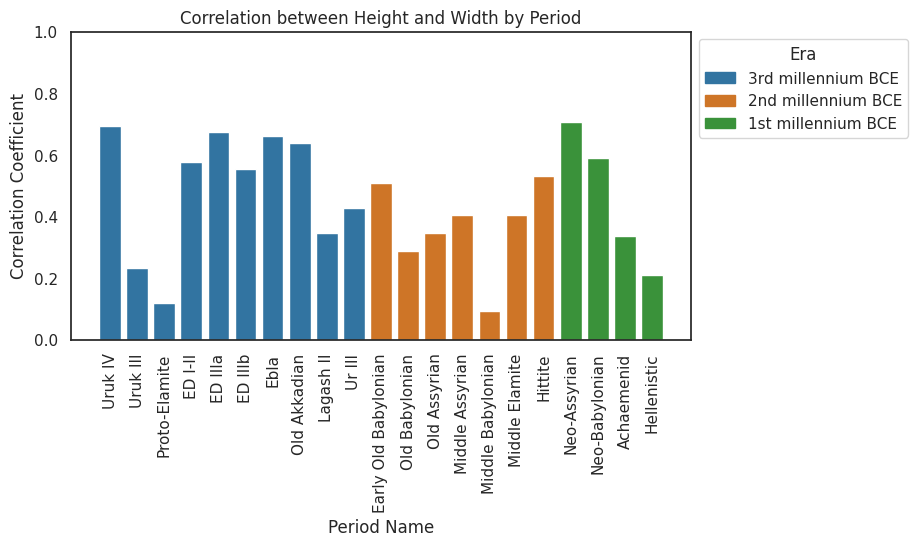

In [28]:
sns.set(style="white")

period_to_era = ratio_df[['Period_Name', 'millennium']].drop_duplicates().set_index('Period_Name')['millennium']

sorted_correlations = ratio_df[['height', 'width', 'Period_Name']].groupby('Period_Name').corr().unstack().iloc[:,1]
period_order = ['Uruk IV', 'Uruk III', 'Proto-Elamite', 'ED I-II', 'ED IIIa', 'ED IIIb', 'Ebla', 'Old Akkadian', 
                'Lagash II', 'Ur III', 'Early Old Babylonian', 'Old Babylonian', 'Old Assyrian', 'Middle Assyrian', 
                'Middle Babylonian', 'Middle Elamite', 'Hittite', 'Neo-Assyrian', 'Neo-Babylonian', 
                'Achaemenid', 'Hellenistic']
sorted_correlations_ordered = sorted_correlations.loc[period_order]
eras_ordered = period_to_era.loc[period_order]

unique_eras = eras_ordered.unique()
# matching colors with previous plots
color_map = {
    '3rd millennium BCE': [50/255, 116/255, 161/255],   
    '2nd millennium BCE': [206/255, 117/255, 39/255],  
    '1st millennium BCE': [58/255, 146/255, 58/255]    
}

bar_colors = eras_ordered.map(color_map)

plt.figure(figsize=(8, 4))  # Adjusted for better visibility
bars = plt.bar(sorted_correlations_ordered.index, 
               sorted_correlations_ordered.values, 
               color=bar_colors,
              align='center')

handles = [plt.Rectangle((0,0),1,1, color=color_map[era]) for era in unique_eras]
plt.legend(handles, unique_eras, title='Era', bbox_to_anchor=(1.0, 1), loc='upper left')

plt.title('Correlation between Height and Width by Period')
plt.ylabel('Correlation Coefficient')
plt.xlabel('Period Name')
plt.ylim(0, 1)
plt.xticks(rotation=90, ha='center')
plt.show()


In [29]:
ratio_df[ratio_df['hw_ratio']<0.6].Period_Name.value_counts()

Period_Name
Neo-Assyrian            1601
Old Babylonian           576
Lagash II                351
Neo-Babylonian           336
Early Old Babylonian     329
Ur III                   238
Middle Babylonian        199
Old Akkadian             108
Achaemenid               101
ED IIIb                   83
Middle Elamite            79
Middle Assyrian           77
Old Assyrian              57
other                     38
Proto-Elamite             35
Uruk III                  17
Ebla                      16
Hellenistic               13
ED I-II                    8
ED IIIa                    4
Hittite                    4
Name: count, dtype: int64

### Boxplot opf Height/Width Ratio per Millennium

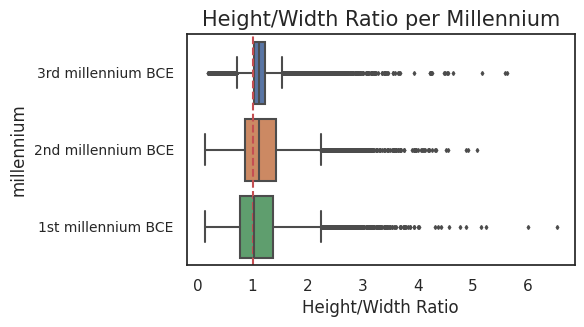

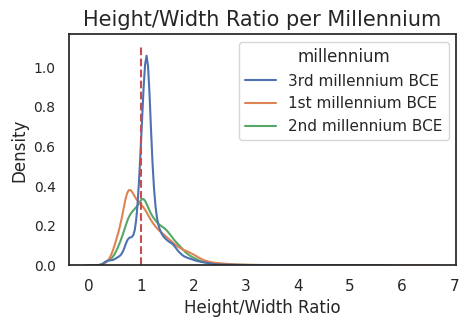

In [43]:
plt.figure(figsize=(5, 3))
millennium_order = ["3rd millennium BCE", "2nd millennium BCE", "1st millennium BCE"]
box_p = sns.boxplot(y='millennium', x='hw_ratio', data=ratio_df[ratio_df['hw_ratio'] < 9], fliersize=2, order=millennium_order)

left, right = plt.ylim()
plt.vlines([1], ymin=left, ymax=right, color='r', linestyles='--')
plt.yticks(fontsize=10)
plt.title('Height/Width Ratio per Millennium', size=15)
plt.xlabel('Height/Width Ratio')

box_pdf_path = 'output/plots/hr_per_mill_box.pdf'
# Uncomment the next line to save the figure
# plt.savefig(box_pdf_path, format='pdf')

plt.show()

plt.figure(figsize=(5, 3))
dist_p = sns.kdeplot(hue = 'millennium', x = 'hw_ratio', data = ratio_df[ratio_df['hw_ratio']<9])
left, right = plt.ylim()
plt.vlines([1], ymin=left, ymax=right, color='r', linestyles='--')
plt.yticks(fontsize=10)
plt.title('Height/Width Ratio per Millennium', size=15);
plt.xlabel('Height/Width Ratio')
kde_pdf_path = 'output/plots/hr_per_mill_kde.pdf'
# plt.savefig(kde_pdf_path, format='pdf')
# plt.close()  
plt.show()

### Histograms of Height/Wodth Ratio per period

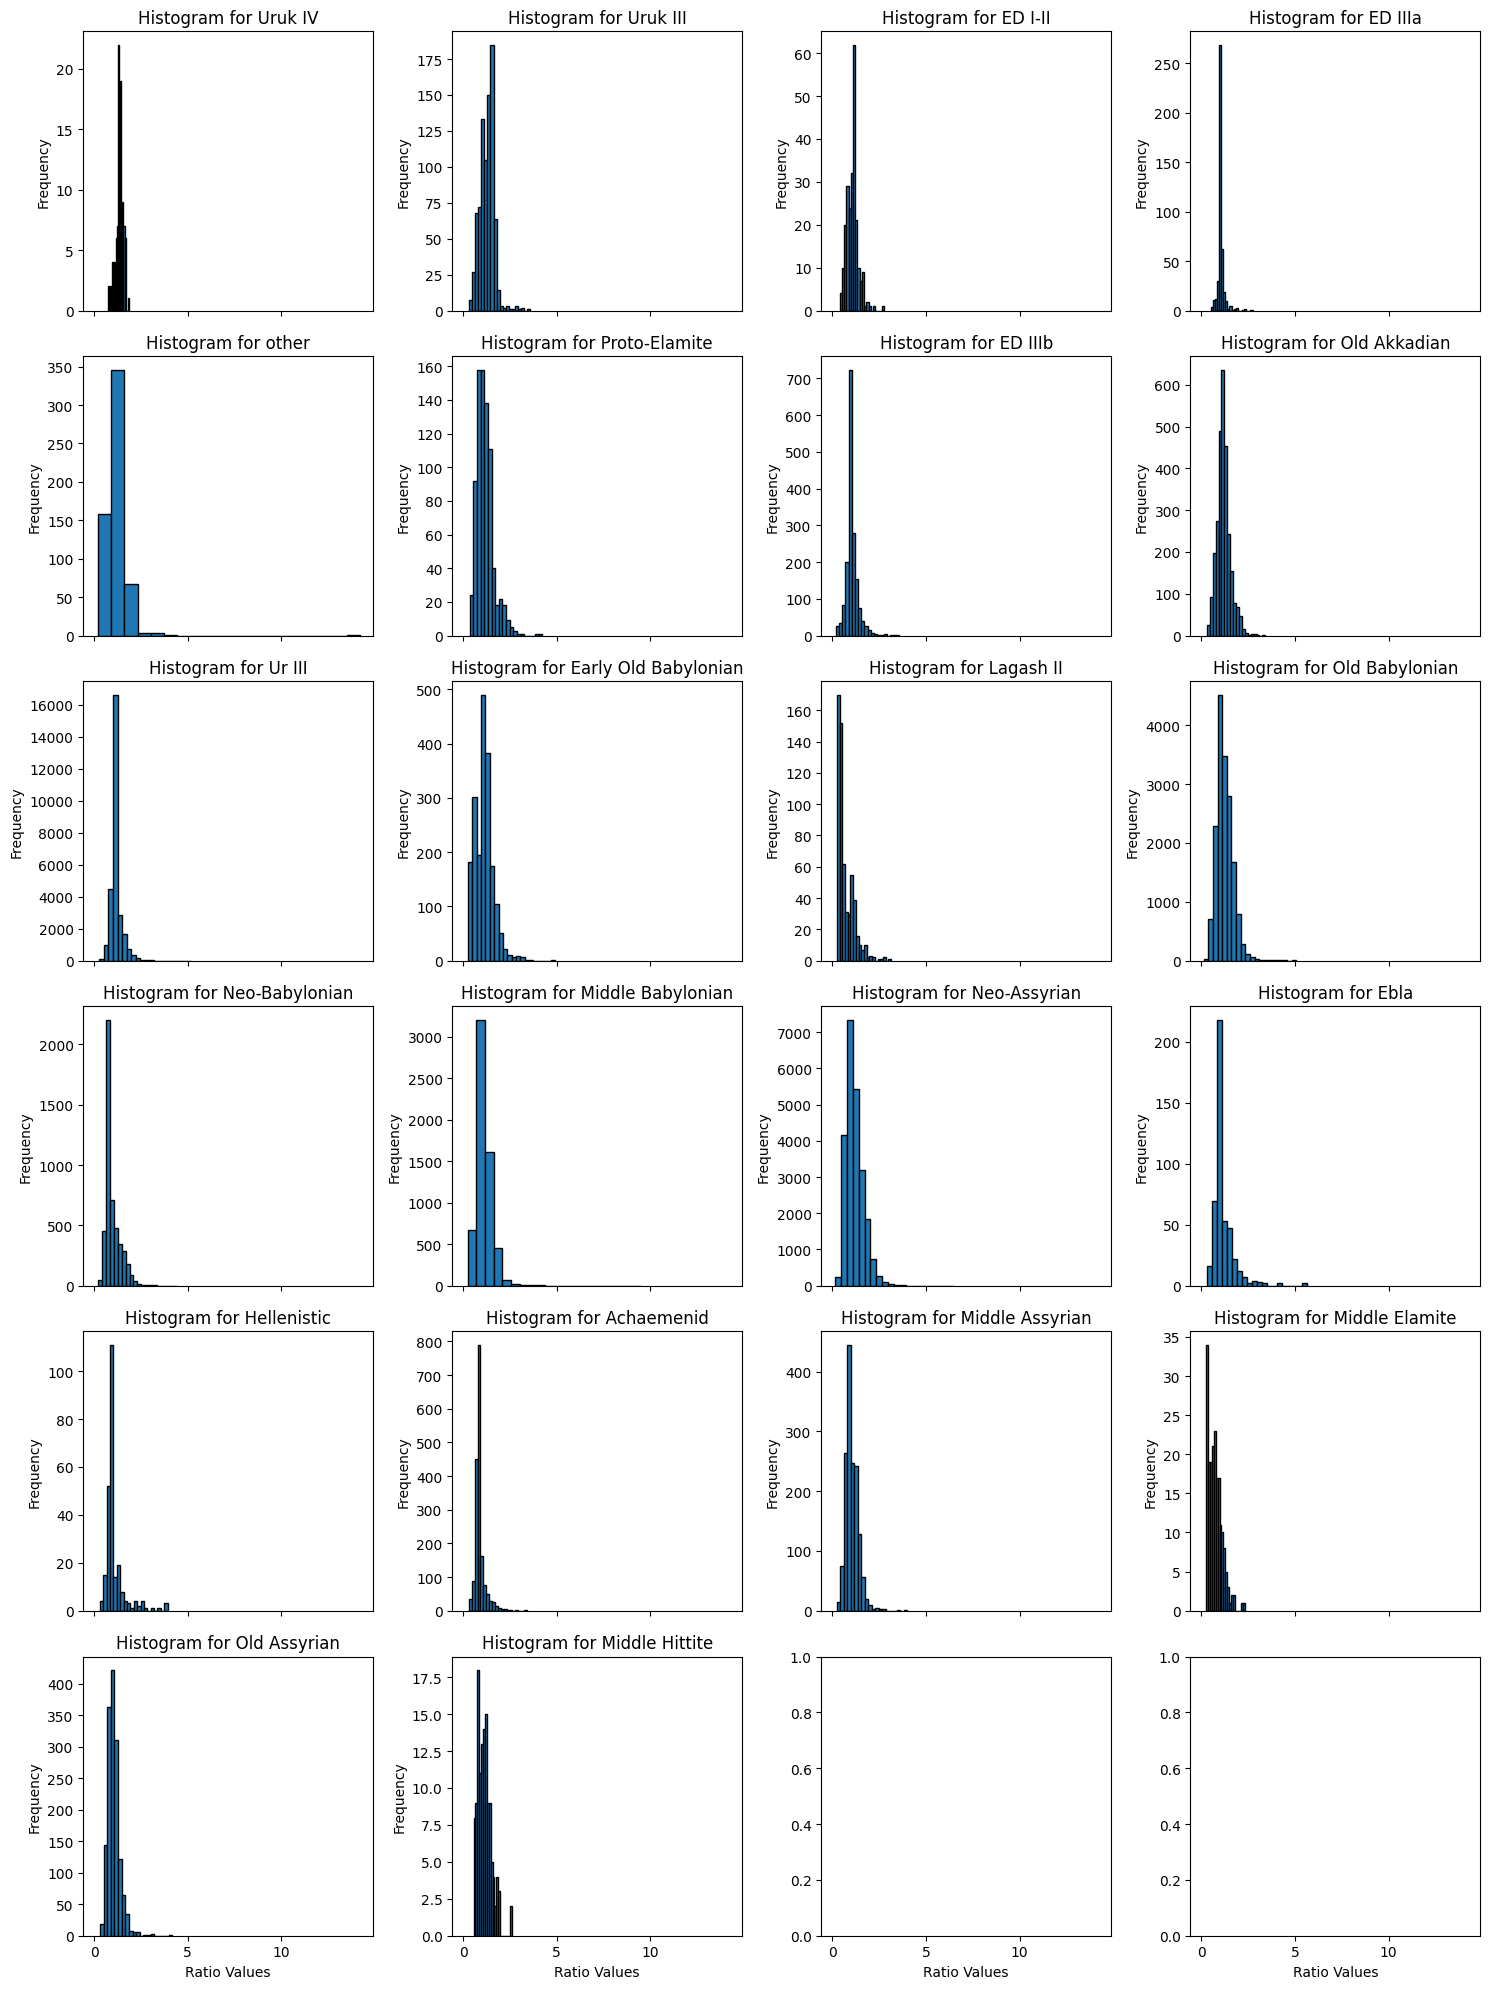

In [25]:
num_periods = ratio_df.period.nunique()
num_cols = 4  
num_rows = -(-num_periods // num_cols)  

fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 20), sharex=True)  # Add 'sharex=True'

for idx, period in enumerate(ratio_df.Period_Name.unique()):
    row = idx // num_cols
    col = idx % num_cols
    period_df = ratio_df[ratio_df['Period_Name']==period]
    # Create histogram in the specified subplot
    axs[row, col].hist(period_df['hw_ratio'], bins=20, edgecolor='black')
    axs[row, col].set_title(f'Histogram for {period}')
    axs[row, col].set_ylabel('Frequency')

for ax in axs[-1, :]:
    ax.set_xlabel('Ratio Values')

plt.tight_layout()
plt.show()

### Boxplot of Height Width Ratio per genre

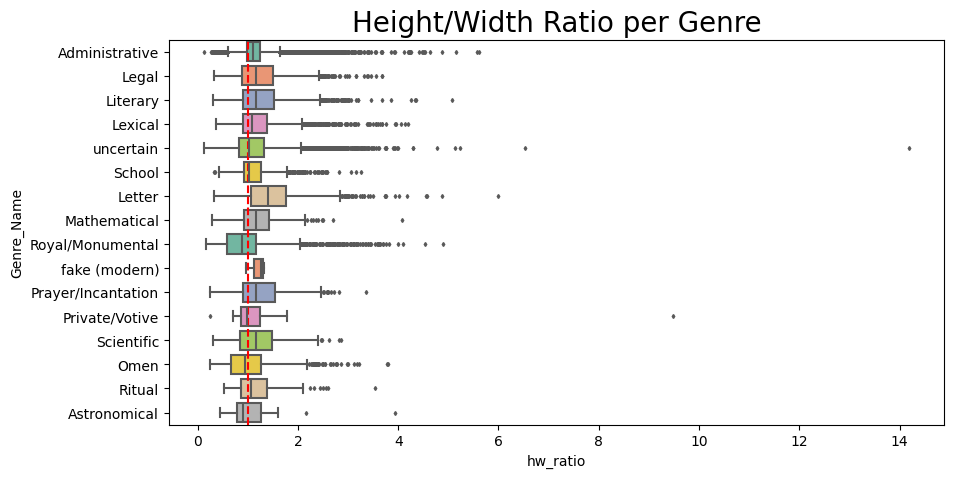

In [26]:
plt.figure(figsize=(10,5))

box_p = sns.boxplot(y='Genre_Name', x='hw_ratio', data=ratio_df, 
                    palette="Set2", fliersize=2)

left, right = plt.ylim()
plt.vlines([1], ymin=left, ymax=right, color='r', linestyles='--')
plt.title('Height/Width Ratio per Genre', size=20)

plt.show()


### Boxplot of Height Width Ratio per period - Order chronoligically

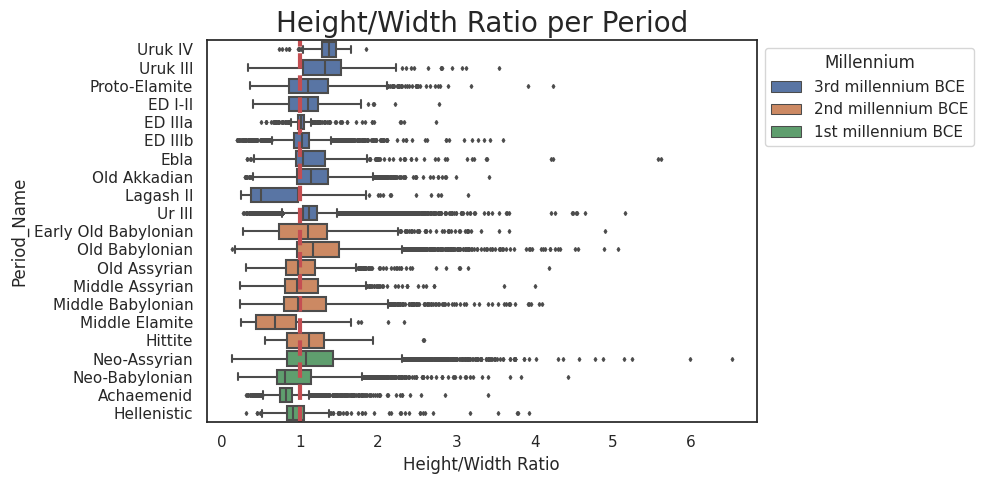

In [30]:
plt.figure(figsize=(10,5))

period_order = ['Uruk IV', 'Uruk III', 'Proto-Elamite', 'ED I-II', 'ED IIIa', 'ED IIIb', 'Ebla', 'Old Akkadian', 'Lagash II', 
                'Ur III', 'Early Old Babylonian', 'Old Babylonian', 'Old Assyrian', 'Middle Assyrian', 
                'Middle Babylonian', 'Middle Elamite', 'Hittite', 'Neo-Assyrian', 
                'Neo-Babylonian', 'Achaemenid', 'Hellenistic']

millennium_order = ['3rd millennium BCE', '2nd millennium BCE', '1st millennium BCE']

period_index = {period: i for i, period in enumerate(period_order)}
ratio_df['Period_Index'] = ratio_df['Period_Name'].map(period_index)

box_p = sns.boxplot(y='Period_Name', x='hw_ratio', data= ratio_df[ratio_df['hw_ratio']<9], hue='millennium', hue_order=millennium_order,
                    order=period_order, fliersize=2, dodge=False)

left, right = plt.ylim()
plt.vlines([1], ymin=left, ymax=right, color='r', linestyles='--', linewidth=3)
plt.title('Height/Width Ratio per Period', size=20)
plt.legend(title='Millennium', bbox_to_anchor=(1.0, 1), loc='upper left')
plt.xlabel('Height/Width Ratio')
plt.tight_layout()
# box_pdf_path = 'output/plots/hwr_per_period_box.pdf'
# plt.savefig(box_pdf_path, format='pdf')
# plt.close()  
plt.show()


#### Seperated by millennium

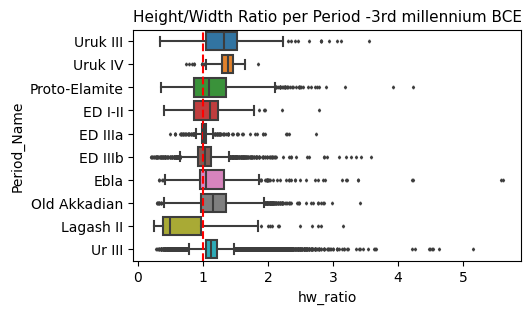

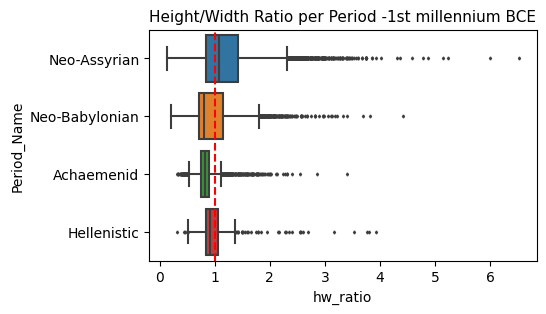

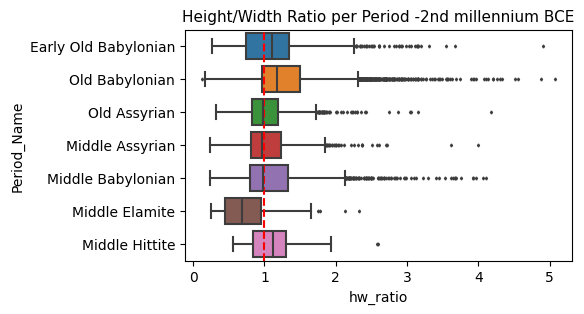

In [29]:
for millennium in ratio_df["millennium"].unique():
    if millennium == "1st millennium BCE":
        period_order=['Neo-Assyrian', 'Neo-Babylonian', 'Achaemenid', 'Hellenistic']

    elif millennium == "2nd millennium BCE":
        period_order=['Early Old Babylonian', 'Old Babylonian', 'Old Assyrian', 'Middle Assyrian', 
                'Middle Babylonian', 'Middle Elamite', 'Hittite']
    else:
        period_order=['Uruk III', 'Uruk IV', 'Proto-Elamite', 'ED I-II', 'ED IIIa', 'ED IIIb', 'Ebla', 'Old Akkadian', 'Lagash II', 
        'Ur III']
    
    plt.figure(figsize=(5, 3))
    box_p = sns.boxplot(y = 'Period_Name', x = 'hw_ratio', data = ratio_df[(ratio_df["millennium"]==millennium)&(ratio_df["Period_Name"]!='other')&(ratio_df['hw_ratio']<9)], 
                        order=period_order, fliersize=1.5)
    left, right = plt.ylim()
    plt.vlines([1], ymin=left, ymax=right, color='r', linestyles='--')
    plt.yticks(fontsize=10)
    plt.title('Height/Width Ratio per Period -' + millennium, size=11);
    # plt.savefig('output/plots/hr_per_period_in_mill_box'+millennium+'.pdf', format='pdf')
    #plt.close()  
    plt.show()

## Linear Correlation betweeen Height and Width, per Genre and Period, and per Millennium

In [30]:
ratio_df[['height', 'width','Genre_Name']].groupby('Genre_Name').corr().unstack().iloc[:,1].sort_values()

Genre_Name
Private/Votive       -0.152864
School                0.196362
Legal                 0.352271
Astronomical          0.362460
fake (modern)         0.395997
Scientific            0.407551
Administrative        0.423117
Literary              0.449515
Lexical               0.500198
Ritual                0.534811
Prayer/Incantation    0.539514
Letter                0.627587
Royal/Monumental      0.629991
uncertain             0.650323
Mathematical          0.658262
Omen                  0.672935
Name: (height, width), dtype: float64

In [31]:
ratio_df[['height', 'width','Period_Name']].groupby('Period_Name').corr().unstack().iloc[:,1].sort_values()

Period_Name
Middle Babylonian       0.092047
Proto-Elamite           0.118350
Hellenistic             0.210811
Uruk III                0.231965
Old Babylonian          0.289517
Achaemenid              0.336801
Lagash II               0.345449
Old Assyrian            0.347476
Middle Assyrian         0.403659
Middle Elamite          0.404498
Ur III                  0.428657
other                   0.432404
Early Old Babylonian    0.507393
Middle Hittite          0.531630
ED IIIb                 0.555420
ED I-II                 0.578283
Neo-Babylonian          0.590533
Old Akkadian            0.639636
Ebla                    0.662321
ED IIIa                 0.674203
Uruk IV                 0.693446
Neo-Assyrian            0.706357
Name: (height, width), dtype: float64

In [32]:
ratio_df[ratio_df['millennium']=='1st millennium BCE'][['height', 'width']].corr()

,height,width
height,1.000000,0.674597
width,0.674597,1.000000


In [33]:
ratio_df[ratio_df['millennium']=='2nd millennium BCE'][['height', 'width']].corr()

,height,width
height,1.000000,0.316829
width,0.316829,1.000000


In [34]:
ratio_df[(ratio_df['millennium']=='3rd millennium BCE')&(ratio_df['period']!="other")][['height', 'width']].corr()

,height,width
height,1.000000,0.514873
width,0.514873,1.000000


## Scatter plot of Height vs. Width per Millennium

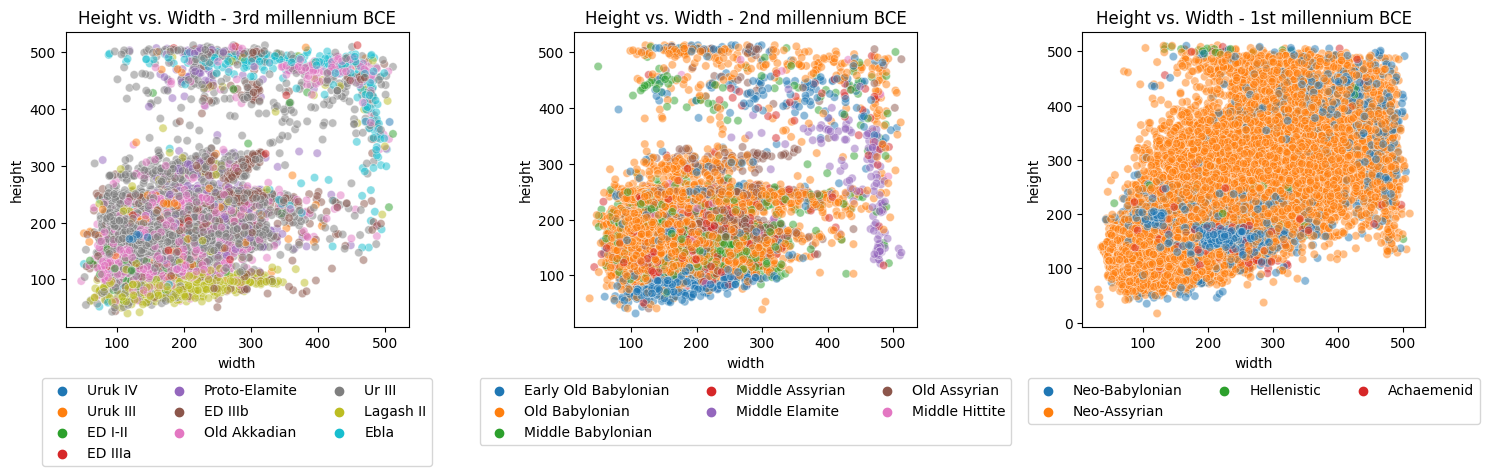

In [35]:
unique_millenniums = ratio_df[ratio_df["Period_Name"] != 'other']["millennium"].unique()

fig, axes = plt.subplots(1, len(unique_millenniums), figsize=(15, 5))  # Adjust the figsize based on the number of millenniums

for i, millennium in enumerate(unique_millenniums):
    ax = axes[i]
    plot = sns.scatterplot(x='width', y='height', hue='Period_Name', 
                    data=ratio_df[(ratio_df["millennium"] == millennium) & (ratio_df["Period_Name"] != 'other')],
                    alpha=0.5, ax=ax)
    
    ax.set_title("Height vs. Width - " + millennium)

    # Place a legend below each subplot
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)

# Adjust the layout
plt.tight_layout()

plt.show()


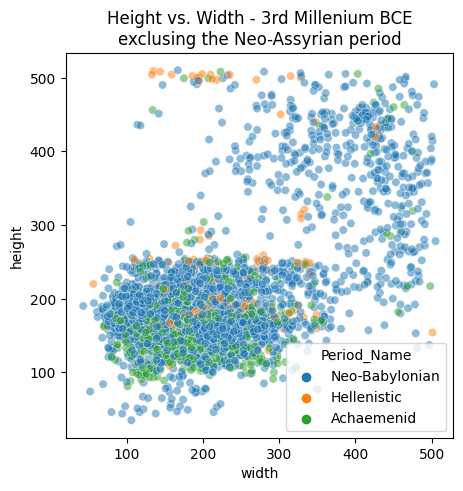

In [36]:
plt.figure(figsize=(5, 5))
sns.scatterplot(y='height', x ='width', hue='Period_Name', data=ratio_df[(ratio_df["millennium"]=='1st millennium BCE')&~(ratio_df["Period_Name"].isin(['other', 'Neo-Assyrian']))], alpha = 0.5)
plt.title("Height vs. Width - 3rd Millenium BCE\nexclusing the Neo-Assyrian period")
plt.show()

<Axes: xlabel='width', ylabel='height'>

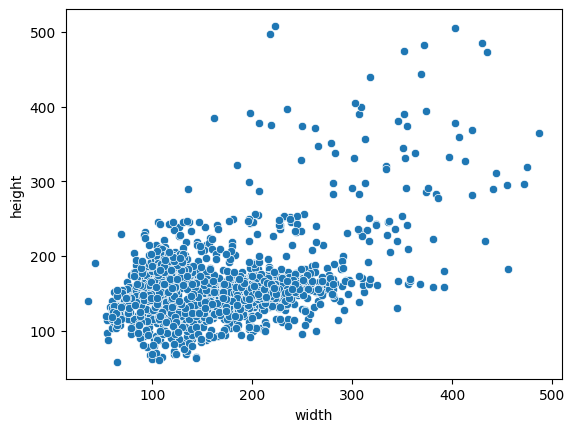

In [38]:
 sns.scatterplot(x='width', y='height', data=ratio_df[(ratio_df["millennium"] == millennium) & (ratio_df["Genre_Name"] == 'Administrative')])


### Scatter plot of Height vs. Width per Genre per Millennium

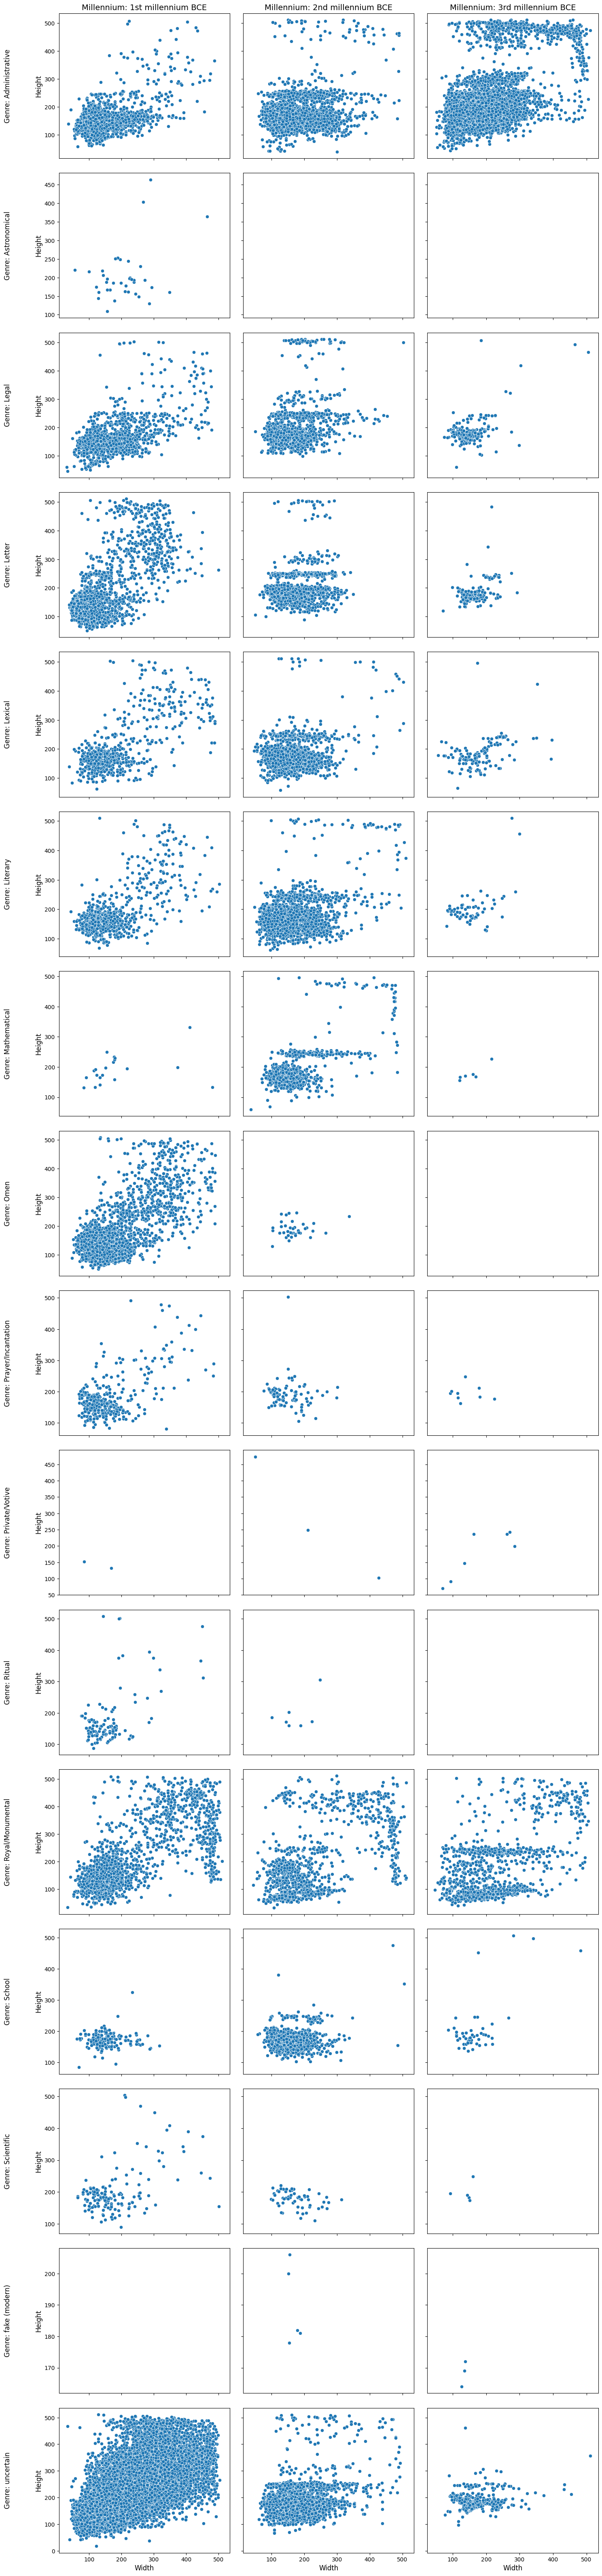

In [39]:
max_cols = 3  # One column for each millennium

unique_genres = sorted(ratio_df["Genre_Name"].unique())

n_rows = len(unique_genres)

fig_width = max_cols * 5  # Decrease width for smaller plots
fig_height = n_rows * 4  # Decrease height accordingly
fig, axes = plt.subplots(n_rows, max_cols, figsize=(fig_width, fig_height), sharex='col', sharey='row')

# Ensure axes is a 2D array even if there's only one row
if n_rows == 1:
    axes = np.array([axes])

# Labeling and plotting for each subplot
for i, genre in enumerate(unique_genres):
    for j, millennium in enumerate(sorted(ratio_df["millennium"].unique())):
        ax = axes[i, j]
        df_filtered = ratio_df[(ratio_df["millennium"] == millennium) & (ratio_df["Genre_Name"] == genre)]
        
        sns.scatterplot(x='width', y='height', data=df_filtered, ax=ax)
        
        if i == 0:
            ax.set_title(f'Millennium: {millennium}', fontsize=14)
        if j == 0:
            ax.text(-0.3, 0.5, f'Genre: {genre}', fontsize=12, rotation=90,
                    ha='center', va='center', transform=ax.transAxes)

        if i == n_rows - 1:
            ax.set_xlabel('Width', fontsize=12)
        if j == 0:
            ax.set_ylabel('Height', fontsize=12)

plt.tight_layout(pad=2.0)

plt.show()


# Period Prediction

In [40]:
num_classes = len(TabletPeriodDataset.PERIOD_INDICES)
num_classes

22

## Preparing datasets

In [41]:
X_train, y_train = ratio_df_train[['hw_ratio']], ratio_df_train['period']
X_val, y_val = ratio_df_val[['hw_ratio']], ratio_df_val['period']
X_test, y_test = ratio_df_test[['hw_ratio']], ratio_df_test['period']

## Computing class Weights

In [42]:
class_labels = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=y_train)

weights_dict = dict(zip(class_labels, class_weights))

## Training the model

In [43]:
dt_model = DecisionTreeClassifier(max_depth=8, min_samples_split=5, class_weight=weights_dict, random_state=42)
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight={0: 7.376456876456876,
                                     1: 0.15372408684070973,
                                     2: 0.18402803018187633,
                                     3: 0.2566105566179899,
                                     4: 0.7175601368076945,
                                     5: 0.8865387309146939,
                                     6: 1.587940118758886,
                                     7: 2.5216813865462515,
                                     8: 2.251912471090553, 9: 2.551501713364241,
                                     10: 2.8413019079685746,
                                     11: 2.896125686394143,
                                     12: 5.121931480981926,
                                     13: 5.254462432544624,
                                     14: 7.16220294228593, 15: 9.35550628233555,
                                     16: 9.920062695924765,
                                     17: 16.922459893048128,
                                     18: 18.362669245647968,
                                     19: 21.988419224088013,
                                     20: 34.18001800180018,
                                     21: 38.35757575757576},
                       max_depth=8, min_samples_split=5, random_state=42)

In [44]:
preds = dt_model.predict(X_test)

In [45]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        52
           1       0.58      0.30      0.40      2799
           2       0.39      0.06      0.10      2304
           3       0.27      0.06      0.10      1671
           4       0.00      0.00      0.00       602
           5       0.20      0.27      0.23       502
           6       0.05      0.05      0.05       309
           7       0.10      0.37      0.16       200
           8       0.00      0.00      0.00       205
           9       0.05      0.09      0.06       169
          10       0.00      0.00      0.00       149
          11       0.00      0.00      0.00       147
          12       0.03      0.10      0.05        79
          13       0.00      0.00      0.00        68
          14       0.11      0.39      0.18        64
          15       0.01      0.02      0.01        48
          16       0.02      0.47      0.03        49
          17       0.01    

/home/kapond/.conda/envs/dani_torch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kapond/.conda/envs/dani_torch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kapond/.conda/envs/dani_torch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

In [46]:
EARLY_BRONZE = {
    'Old Akkadian', 'Ur III',
    'ED IIIb', 'Uruk III',
    'Proto-Elamite', 'Lagash II',
    'Ebla', 'ED IIIa', 'ED I-II',
    'Uruk IV', 'Linear Elamite',
    'Harappan'
}
MID_LATE_BRONZE = {
    'Early Old Babylonian',
    'Old Babylonian', 'Old Assyrian',
    'Middle Babylonian', 'Middle Assyrian',
    'Middle Elamite', 'Hittite'
}
IRON = {
    'Neo-Babylonian', 'Neo-Assyrian',
    'Achaemenid', 'Hellenistic',
    'Neo-Elamite'
}
ERA_MAP = {
    **{K: 'EB' for K in EARLY_BRONZE},
    **{K: 'MLB' for K in MID_LATE_BRONZE},
    **{K: 'I' for K in IRON},
}

In [47]:
def explain(period):
    return f'{period} ({ERA_MAP.get(period, "?")})'

In [48]:
idx2period = {v: k for k, v in TabletPeriodDataset.PERIOD_INDICES.items()}
idx2period[0] = 'other'

In [49]:
# let's just use classes with support >=10, everything else goes to 0: other
COMMON_LABELS = list({k for k, v in Counter(y_test).items() if v >= 40})
print(f'Common labels: ({len(COMMON_LABELS)})')
[(i, explain(idx2period[i])) for i in COMMON_LABELS]

Common labels: (17)


[(0, 'other (?)'),
 (1, 'Ur III (EB)'),
 (2, 'Neo-Assyrian (I)'),
 (3, 'Old Babylonian (MLB)'),
 (4, 'Middle Babylonian (MLB)'),
 (5, 'Neo-Babylonian (I)'),
 (6, 'Old Akkadian (EB)'),
 (7, 'Achaemenid (I)'),
 (8, 'Early Old Babylonian (MLB)'),
 (9, 'ED IIIb (EB)'),
 (10, 'Middle Assyrian (MLB)'),
 (11, 'Old Assyrian (MLB)'),
 (12, 'Uruk III (EB)'),
 (13, 'Proto-Elamite (EB)'),
 (14, 'Lagash II (EB)'),
 (15, 'Ebla (EB)'),
 (16, 'ED IIIa (EB)')]

In [50]:
y_true_c = y_test.copy()
y_true_c[~np.isin(y_test, COMMON_LABELS)] = 0
print((~np.isin(y_test, COMMON_LABELS)).mean(), 'changed to "other"')

0.00811038550663577 changed to "other"


In [51]:
y_pred_c = preds.copy()
y_pred_c[~np.isin(preds, COMMON_LABELS)] = 0
print((~np.isin(preds, COMMON_LABELS)).mean(), 'changed to "other"')

0.3590688856119654 changed to "other"


In [52]:
indices_c = list(set(y_true_c) | set(y_pred_c))
print(len(indices_c))
print(indices_c)
PERIOD_LABELS_C = [explain(idx2period[i]) for i in indices_c]
print(PERIOD_LABELS_C)

17
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
['other (?)', 'Ur III (EB)', 'Neo-Assyrian (I)', 'Old Babylonian (MLB)', 'Middle Babylonian (MLB)', 'Neo-Babylonian (I)', 'Old Akkadian (EB)', 'Achaemenid (I)', 'Early Old Babylonian (MLB)', 'ED IIIb (EB)', 'Middle Assyrian (MLB)', 'Old Assyrian (MLB)', 'Uruk III (EB)', 'Proto-Elamite (EB)', 'Lagash II (EB)', 'Ebla (EB)', 'ED IIIa (EB)']


In [53]:
print(classification_report(y_true_c, y_pred_c, target_names=PERIOD_LABELS_C))

                            precision    recall  f1-score   support

                 other (?)       0.02      0.45      0.03       129
               Ur III (EB)       0.58      0.30      0.40      2799
          Neo-Assyrian (I)       0.39      0.06      0.10      2304
      Old Babylonian (MLB)       0.27      0.06      0.10      1671
   Middle Babylonian (MLB)       0.00      0.00      0.00       602
        Neo-Babylonian (I)       0.20      0.27      0.23       502
         Old Akkadian (EB)       0.05      0.05      0.05       309
            Achaemenid (I)       0.10      0.37      0.16       200
Early Old Babylonian (MLB)       0.00      0.00      0.00       205
              ED IIIb (EB)       0.05      0.09      0.06       169
     Middle Assyrian (MLB)       0.00      0.00      0.00       149
        Old Assyrian (MLB)       0.00      0.00      0.00       147
             Uruk III (EB)       0.03      0.10      0.05        79
        Proto-Elamite (EB)       0.00      0.00

/home/kapond/.conda/envs/dani_torch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kapond/.conda/envs/dani_torch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kapond/.conda/envs/dani_torch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

In [54]:
y_prob = dt_model.predict_proba(X_test)
Y = label_binarize(y_test, classes=np.unique(y_test))
n_classes = Y.shape[1]

auc_scores = []
for i in range(n_classes):
    auc = roc_auc_score(Y[:, i], y_prob[:, i])
    auc_scores.append(auc)

macro_ovr_auc = np.mean(auc_scores)
print(f"Macro-OvR-AUC: {macro_ovr_auc}")

Macro-OvR-AUC: 0.6378889304442091


In [55]:
def period_to_millennium(period):
    if period in ['Uruk III', 'Uruk IV', 'Proto-Elamite', 'ED I-II', 'ED IIIa', 'ED IIIb', 'Ebla', 'Old Akkadian', 'Lagash II', 
                                                                         'Ur III']:
        return "3rd millennium BCE"
    elif period in ['Early Old Babylonian', 'Old Babylonian', 'Old Assyrian', 'Middle Assyrian', 
                                                                        'Middle Babylonian', 'Middle Elamite', 'Hittite']:
        return "2nd millennium BCE"
    else:
        return "1st millennium BCE"

# Apply the function to the 'period' column to create a new 'millennium' column
df['millennium'] = df['period_normed'].apply(period_to_millennium)

In [56]:
df.loc[df['height']=='?', 'height'] = np.nan
df.loc[df['width']=='?', 'width'] = np.nan
df.loc[df['thickness']=='?', 'thickness'] = np.nan

In [57]:
df['height']=pd.to_numeric(df['height'], errors='coerce')
df['width']=pd.to_numeric(df['width'], errors='coerce')
df['thickness']=pd.to_numeric(df['thickness'], errors='coerce')

In [58]:
df['h_w_ratio']=df['height']/df['width']

In [59]:
set(df[df['h_w_ratio']<100].dropna(subset=['height'])['period_normed'])

{'ED I-II',
 'ED IIIa',
 'ED IIIb',
 'Early Old Babylonian',
 'Ebla',
 'Lagash II',
 'Middle Assyrian',
 'Middle Babylonian',
 'Middle Elamite',
 'Middle Hittite',
 'Neo-Assyrian',
 'Neo-Babylonian',
 'Old Akkadian',
 'Old Assyrian',
 'Old Babylonian',
 'Proto-Elamite',
 'Ur III',
 'Uruk III',
 'Uruk IV'}

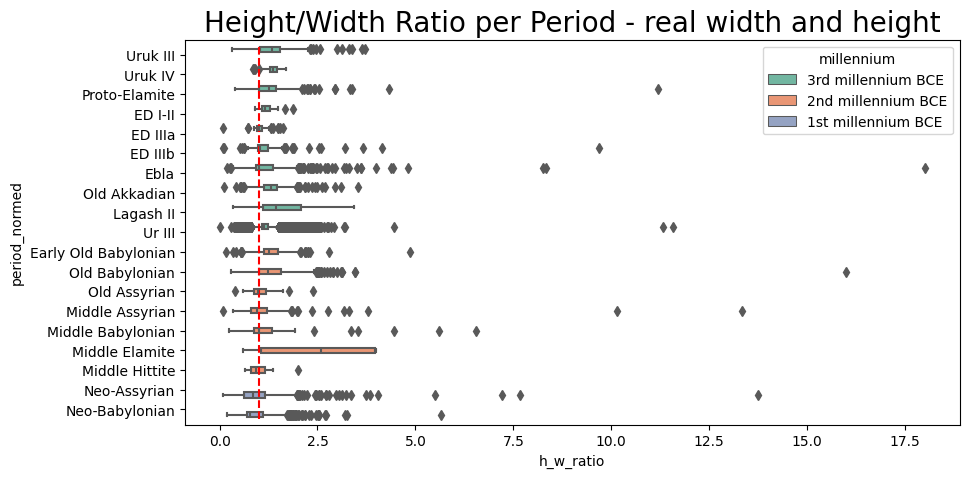

In [60]:
plt.figure(figsize=(10,5))

period_order = ['Uruk III', 'Uruk IV', 'Proto-Elamite', 'ED I-II', 'ED IIIa', 'ED IIIb', 'Ebla', 'Old Akkadian', 'Lagash II', 
                'Ur III', 'Early Old Babylonian', 'Old Babylonian', 'Old Assyrian', 'Middle Assyrian', 
                'Middle Babylonian', 'Middle Elamite', 'Hittite', 'Neo-Assyrian', 
                'Neo-Babylonian']# 'Achaemenid', 'Hellenistic']

period_index = {period: i for i, period in enumerate(period_order)}
df['Period_Index'] = df['period_normed'].map(period_index)

box_p = sns.boxplot(y='period_normed', x='h_w_ratio', data=df[df['h_w_ratio']<100].dropna(subset=['height']), hue='millennium',
                    order=period_order, palette="Set2")

left, right = plt.ylim()
plt.title('Height/Width Ratio per Period - real width and height', size=20)
plt.vlines([1], ymin=left, ymax=right, color='r', linestyles='--')

plt.show()
